In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import seaborn as sns

from settings import *
from utils import *
from quoteExtraction import *
from gloveEmbeddings import *

from pyspark.sql import SQLContext
from pyspark import SparkConf, SparkContext
if useSpark: ctx = SQLContext(SparkContext(conf = (SparkConf().setMaster('local[*]').setAppName('quoteExtraction').set('spark.executor.memory', '2G').set('spark.driver.memory', '40G').set('spark.driver.maxResultSize', '10G'))))

In [2]:
def findQuoteTopic(quote, tEmbeddings):

    maxSim = 0.0
    topic = np.nan
    quoteVec = sent2Vec(quote)

    for t, vec in tEmbeddings.items():
        curSim = sim(quoteVec, vec)
        if curSim > maxSim:
            maxSim = curSim
            topic = t

    return topic, maxSim

def quoteExtraction(limitDocuments=10):
    query = createQuery(limitDocuments, 'web')
    documents = queryDB(query)        

    if useSpark:
        rddd = ctx.createDataFrame(documents[['title','body']]).rdd
        documents['quotes'] = rddd.map(lambda s: dependencyGraphSearch(s.title, s.body)).collect()
    else:
        documents['quotes'] = documents.apply(lambda d: dependencyGraphSearch(d['title'],d['body']), axis=1)
    
    documents = documents[['topic_label']].join(documents['quotes'].apply(pd.Series).stack().reset_index(level=1, drop=True).apply(pd.Series))
    
    print ('#quotesPerDocument: ',len(documents)/limitDocuments)
    
    
    documents = documents.dropna() #TODO
    print('Total number of quotes:',human_format(documents.shape[0]))
    print('Total number of topics:', len(documents.topic_label.unique()))

    topics = documents.topic_label.unique()
    tEmbeddings = topics2Vec(topics)
    documents['quoteTopic'], documents['sim'] = zip(*documents['quote'].map(lambda x: findQuoteTopic(x, tEmbeddings)))
    
    return documents

if useCache:
    documents = pd.read_pickle(cachedDataFrame)
else:
    documents = quoteExtraction(100)
    documents.to_pickle(cachedDataFrame)

#quotesPerDocument:  6.2
Total number of quotes: 620
Total number of topics: 25


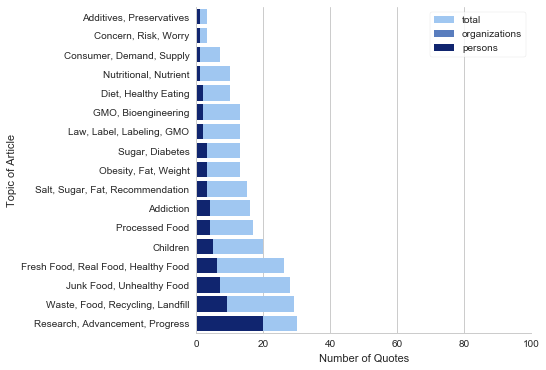

In [3]:
def plotNumOfQuotes():
    
    #Filter (aesthetic purposes)
    countLimit = 1

    #Data manipulation
    total = pd.DataFrame(documents.groupby(['topic_label']).size().sort_values().rename('count')).reset_index()
    total = total[total['count'] > countLimit]
    topics = total['topic_label']
    person = pd.DataFrame(documents.query("quoteeType=='PERSON' & topic_label in @topics").groupby(['topic_label']).size().sort_values().rename('count')).reset_index()
    personorg = pd.DataFrame(documents.query("quoteeType in ['PERSON', 'ORG'] & topic_label in @topics").groupby(['topic_label']).size().sort_values().rename('count')).reset_index()

    #Aesthetics
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 6))

    #Barplots
    sns.set_color_codes("pastel")
    sns.barplot(x="count", y="topic_label", data=total, ax=ax, label="total", color='b')
    sns.set_color_codes("muted")
    sns.barplot(x="count", y="topic_label", data=personorg, ax=ax, label="organizations", color='b')
    sns.set_color_codes("dark")
    sns.barplot(x="count", y="topic_label", data=person, ax=ax, label="persons", color='b')

    #Labels
    ax.set(ylabel="Topic of Article", xlabel="Number of Quotes")
    ax.legend(ncol=1, loc="upper right", frameon=True)
    sns.despine()
    locs, labels = plt.xticks()
    labels = [human_format(l) for l in locs]
    plt.xticks(locs, labels)

    #Depiction
    plt.savefig('plots/CountQuotees.png', dpi=1200, bbox_inches = 'tight')
    plt.show()

plotNumOfQuotes()

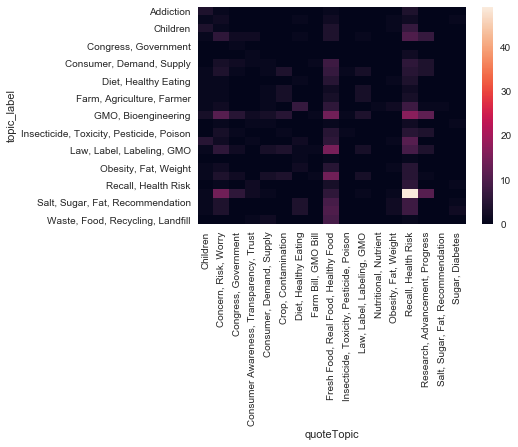

In [4]:
def plotHeatMap():
    sns.heatmap(documents[['topic_label', 'quoteTopic', 'sim']].groupby(['topic_label', 'quoteTopic']).count().reset_index().pivot(index='topic_label', columns='quoteTopic', values='sim').fillna(0))
plotHeatMap()